In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from dataset import get_MNIST_data
from model import CNN
from lion_pytorch import Lion as pytorch_Lion
import time
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_SPLIT = 0.75
BATCH_SIZE = 64
EPOCHS = 10

In [2]:
traindata, testdata, valdata = get_MNIST_data(TRAIN_SPLIT)
traindataloader = DataLoader(traindata, batch_size=BATCH_SIZE)
valdataloader = DataLoader(valdata, batch_size=BATCH_SIZE)
testdataloader = DataLoader(testdata, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainsteps = len(traindataloader.dataset) // BATCH_SIZE
valsteps = len(valdataloader.dataset) // BATCH_SIZE

In [3]:
print("[INFO] initializing the CNN model...")
model = CNN(layers=[
	{"in_ch": 1, "out_ch": 10, "conv_k_sz": 5, "maxp_k_sz": 2, "maxp_str": 2}
], num_classes=10, lin_features=1960).to(device)

[INFO] initializing the CNN model...


In [4]:
#opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-3)
opt = pytorch_Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

lossFn = torch.nn.NLLLoss()

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

In [5]:
print("[INFO] training the network...")
startTime = time.time()
# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in traindataloader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valdataloader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainsteps
	avgValLoss = totalValLoss / valsteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(traindataloader.dataset)
	valCorrect = valCorrect / len(valdataloader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testdataloader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testdata.targets.cpu().numpy(),
	np.array(preds), target_names=testdata.classes))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.511220, Train accuracy: 0.8720
Val loss: 0.214832, Val accuracy: 0.9374

[INFO] EPOCH: 2/10
Train loss: 0.151166, Train accuracy: 0.9561
Val loss: 0.125269, Val accuracy: 0.9635

[INFO] EPOCH: 3/10
Train loss: 0.092327, Train accuracy: 0.9725
Val loss: 0.092647, Val accuracy: 0.9732

[INFO] EPOCH: 4/10
Train loss: 0.065283, Train accuracy: 0.9812
Val loss: 0.079803, Val accuracy: 0.9745

[INFO] EPOCH: 5/10
Train loss: 0.049790, Train accuracy: 0.9861
Val loss: 0.074505, Val accuracy: 0.9768

[INFO] EPOCH: 6/10
Train loss: 0.039530, Train accuracy: 0.9896
Val loss: 0.071760, Val accuracy: 0.9773

[INFO] EPOCH: 7/10
Train loss: 0.032236, Train accuracy: 0.9916
Val loss: 0.072210, Val accuracy: 0.9771

[INFO] EPOCH: 8/10
Train loss: 0.026136, Train accuracy: 0.9935
Val loss: 0.075506, Val accuracy: 0.9763

[INFO] EPOCH: 9/10
Train loss: 0.022099, Train accuracy: 0.9942
Val loss: 0.080801, Val accuracy: 0.9753

[INFO] EPOCH: 1

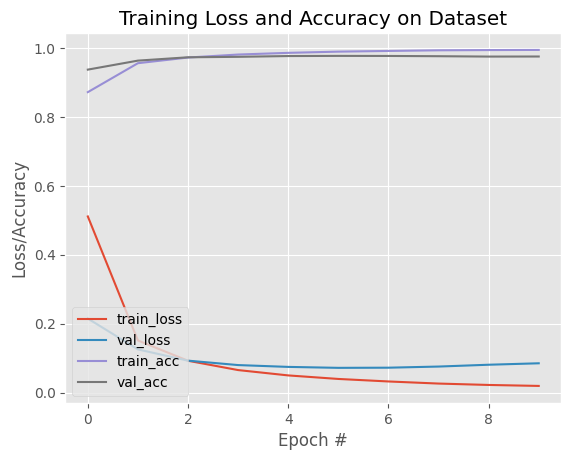

In [6]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()